<a href="https://colab.research.google.com/github/Hafsa620/PAI/blob/main/notebook/train_yolov12_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Nov 19 06:57:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 92.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 854.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 119.1 MB/s eta 0:00:00


### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [4]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-11-19 06:58:39--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-11-19 06:58:39 (98.5 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

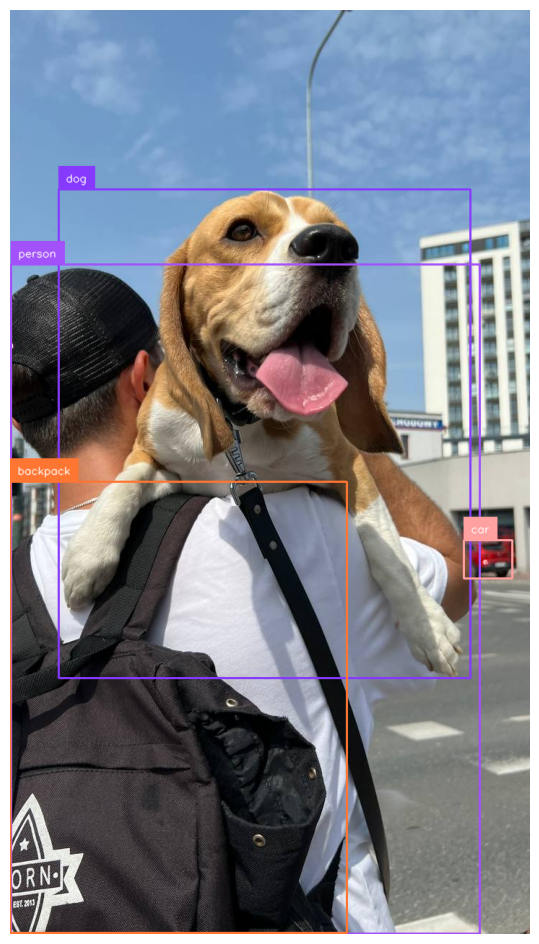

In [6]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [ ]:


!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="NqjtCN1BkDxTg2u1jXzs")
project = rf.workspace("augmented-startups").project("weeds-nxe1w")
version = project.version(3)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Weeds-3 in yolov11:: 100%|██████████| 8418/8418 [00:01<00:00, 4293.90it/s]


In [ ]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [ ]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [ ]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['Weeds']

roboflow:
  workspace: augmented-startups
test: ../test/images
train: ../train/images
val: ../valid/images


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
!unzip /content/drive/MyDrive/Shoplifting-Detection.v2-v2.yolov11.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/train/labels/cam-pos-video-six_hmMP4PE9_mp4-350_jpg.rf.75db0b55052220eab3463dfc18fed7ee.txt  
  inflating: /content/data/train/labels/cam-pos-video-six_hmMP4PE9_mp4-350_jpg.rf.cea532897d9fb2a9073ad8598ea3ea81.txt  
 extracting: /content/data/train/labels/cam-pos-video-six_hmMP4PE9_mp4-353_jpg.rf.4c25dd4dec313cdf4ecd687341241f3a.txt  
 extracting: /content/data/train/labels/cam-pos-video-six_hmMP4PE9_mp4-353_jpg.rf.ae58f71bb897086910f63c605755f809.txt  
 extracting: /content/data/train/labels/cam-pos-video-six_hmMP4PE9_mp4-353_jpg.rf.c467bf6aa69a1324b51ef322f4dba9d6.txt  
  inflating: /content/data/train/labels/cam-pos-video-six_hmMP4PE9_mp4-356_jpg.rf.4383cf8ad724f91dfadea4f0f62d3db9.txt  
  inflating: /content/data/train/labels/cam-pos-video-six_hmMP4PE9_mp4-356_jpg.rf.7843e9ec8ab30a05b020ec6f8ab600b5.txt  
  inflating: /content/data/train/labels/cam-pos-video-six_hmMP4PE9_mp4-356_jpg.rf.bc72064f77ce5ad0f6c9

In [16]:
import yaml

data_yaml_path = "/content/data/data.yaml"

# Load old YAML
with open(data_yaml_path, 'r') as f:
    data = yaml.safe_load(f)

# Update paths
data['train'] = "/content/data/train/images"
data['val']   = "/content/data/valid/images"
data['test']  = "/content/data/test/images"

# Update classes (if needed)
data['nc'] = 2
data['names'] = ["normal","shoplifting"]

# Save YAML
with open(data_yaml_path, 'w') as f:
    yaml.dump(data, f)

print("Updated data.yaml successfully!")


Updated data.yaml successfully!


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [18]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data='/content/data/data.yaml', epochs=30)



New https://pypi.org/project/ultralytics/8.3.229 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/data/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

100%|██████████| 755k/755k [00:00<00:00, 99.3MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 347MB/s]


AMP: checks passed ✅


train: Scanning /content/data/train/labels... 6188 images, 17 backgrounds, 0 corrupt: 100%|██████████| 6188/6188 [00:02<00:00, 2229.20it/s]

train: WARNING ⚠️ /content/data/train/images/teenage-girl-shoplifting-in-department-store-model-re-enactment-bob-daemmrich-2B7W4RX_jpg.rf.5cb1554ae2b935d9712979df144928a7.jpg: 1 duplicate labels removed


train: New cache created: /content/data/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 18, len(boxes) = 7465. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/data/valid/labels... 864 images, 2 backgrounds, 0 corrupt: 100%|██████████| 864/864 [00:00<00:00, 971.03it/s]


val: New cache created: /content/data/valid/labels.cache
Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      6.71G       2.94      3.784      3.517         27        640: 100%|██████████| 387/387 [03:56<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:17<00:00,  1.58it/s]

                   all        864        952      0.104      0.245     0.0737     0.0197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      6.82G      2.298      3.164      2.739         31        640: 100%|██████████| 387/387 [03:26<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.36it/s]


                   all        864        952      0.189      0.269      0.114     0.0419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      6.83G      2.005      2.757       2.38         26        640: 100%|██████████| 387/387 [03:24<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]

                   all        864        952      0.189      0.451      0.189     0.0889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      6.67G      1.797      2.456      2.146         31        640: 100%|██████████| 387/387 [03:25<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.46it/s]

                   all        864        952      0.212      0.379      0.201      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      6.84G      1.625      2.217      1.973         30        640: 100%|██████████| 387/387 [03:24<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.48it/s]

                   all        864        952      0.427      0.436      0.326      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      6.81G      1.525      2.058       1.87         23        640: 100%|██████████| 387/387 [03:24<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.38it/s]

                   all        864        952      0.459      0.503      0.372      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      6.66G      1.432      1.954      1.794         23        640: 100%|██████████| 387/387 [03:24<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.27it/s]

                   all        864        952      0.457      0.457      0.333      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      6.83G      1.385      1.875      1.746         28        640: 100%|██████████| 387/387 [03:24<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.32it/s]

                   all        864        952      0.427      0.496      0.399      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      6.83G      1.339      1.797      1.704         31        640: 100%|██████████| 387/387 [03:24<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.31it/s]

                   all        864        952      0.465      0.554      0.428      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.81G      1.281      1.715      1.658         32        640: 100%|██████████| 387/387 [03:24<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.47it/s]

                   all        864        952      0.522      0.541      0.495      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      6.66G      1.247      1.655      1.617         35        640: 100%|██████████| 387/387 [03:24<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]

                   all        864        952      0.496      0.604      0.515      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.83G      1.208      1.602      1.588         30        640: 100%|██████████| 387/387 [03:24<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.33it/s]

                   all        864        952      0.513      0.631      0.512      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      6.83G      1.174      1.579      1.572         41        640: 100%|██████████| 387/387 [03:23<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.33it/s]

                   all        864        952      0.532      0.662      0.552      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.65G      1.131      1.514      1.541         29        640: 100%|██████████| 387/387 [03:24<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.30it/s]

                   all        864        952      0.567      0.632      0.573      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      6.82G      1.114      1.474      1.518         34        640: 100%|██████████| 387/387 [03:23<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.48it/s]

                   all        864        952      0.583      0.617      0.578      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      6.83G      1.101      1.443      1.516         32        640: 100%|██████████| 387/387 [03:24<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.33it/s]

                   all        864        952      0.607      0.574      0.578      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      6.82G      1.079      1.403      1.495         25        640: 100%|██████████| 387/387 [03:24<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.34it/s]

                   all        864        952      0.622      0.642      0.616      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      6.81G       1.06      1.386      1.483         23        640: 100%|██████████| 387/387 [03:23<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.35it/s]

                   all        864        952      0.649      0.697      0.668      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      6.83G      1.024      1.335      1.454         25        640: 100%|██████████| 387/387 [03:24<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.45it/s]

                   all        864        952      0.652      0.694      0.668      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      6.83G      1.015      1.308      1.446         26        640: 100%|██████████| 387/387 [03:23<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.42it/s]

                   all        864        952      0.681      0.655      0.675      0.476


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      6.66G     0.9505      1.058      1.433         15        640: 100%|██████████| 387/387 [03:25<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.36it/s]

                   all        864        952      0.745       0.68      0.741      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.64G     0.9173     0.9724      1.398         16        640: 100%|██████████| 387/387 [03:23<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.31it/s]

                   all        864        952      0.802      0.732      0.771      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.66G     0.8873     0.9164      1.375         12        640: 100%|██████████| 387/387 [03:23<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.32it/s]

                   all        864        952      0.815      0.735       0.79      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.66G     0.8586      0.869      1.355         13        640: 100%|██████████| 387/387 [03:23<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.39it/s]

                   all        864        952      0.824      0.724      0.778      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.83G      0.842     0.8331      1.334         16        640: 100%|██████████| 387/387 [03:23<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.44it/s]

                   all        864        952       0.83      0.756      0.793      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.65G     0.8212     0.7896      1.321         17        640: 100%|██████████| 387/387 [03:23<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.32it/s]

                   all        864        952      0.842      0.746      0.808      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.83G     0.7885     0.7502       1.29         19        640: 100%|██████████| 387/387 [03:23<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.36it/s]

                   all        864        952      0.868      0.744      0.807      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.82G     0.7833     0.7286      1.287         12        640: 100%|██████████| 387/387 [03:22<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.38it/s]

                   all        864        952      0.858      0.773      0.813      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.66G      0.759     0.7003      1.271         12        640: 100%|██████████| 387/387 [03:24<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.51it/s]

                   all        864        952      0.887       0.76      0.822      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.64G     0.7415      0.674      1.255         14        640: 100%|██████████| 387/387 [03:23<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.34it/s]

                   all        864        952      0.894      0.764      0.815      0.629



30 epochs completed in 1.820 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 18.6MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,982 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:12<00:00,  2.12it/s]


                   all        864        952       0.89      0.757      0.822      0.634
                normal        571        576      0.905      0.639      0.704      0.504
           shoplifting        295        376      0.875      0.875       0.94      0.764
Speed: 0.2ms preprocess, 8.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train3


## Evaluate fine-tuned YOLOv12 model

In [23]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls /content/runs/detect/train3

args.yaml					   train_batch1.jpg
confusion_matrix_normalized.png			   train_batch2.jpg
confusion_matrix.png				   train_batch7740.jpg
events.out.tfevents.1763537781.3c2ae4deaa59.428.0  train_batch7741.jpg
F1_curve.png					   train_batch7742.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


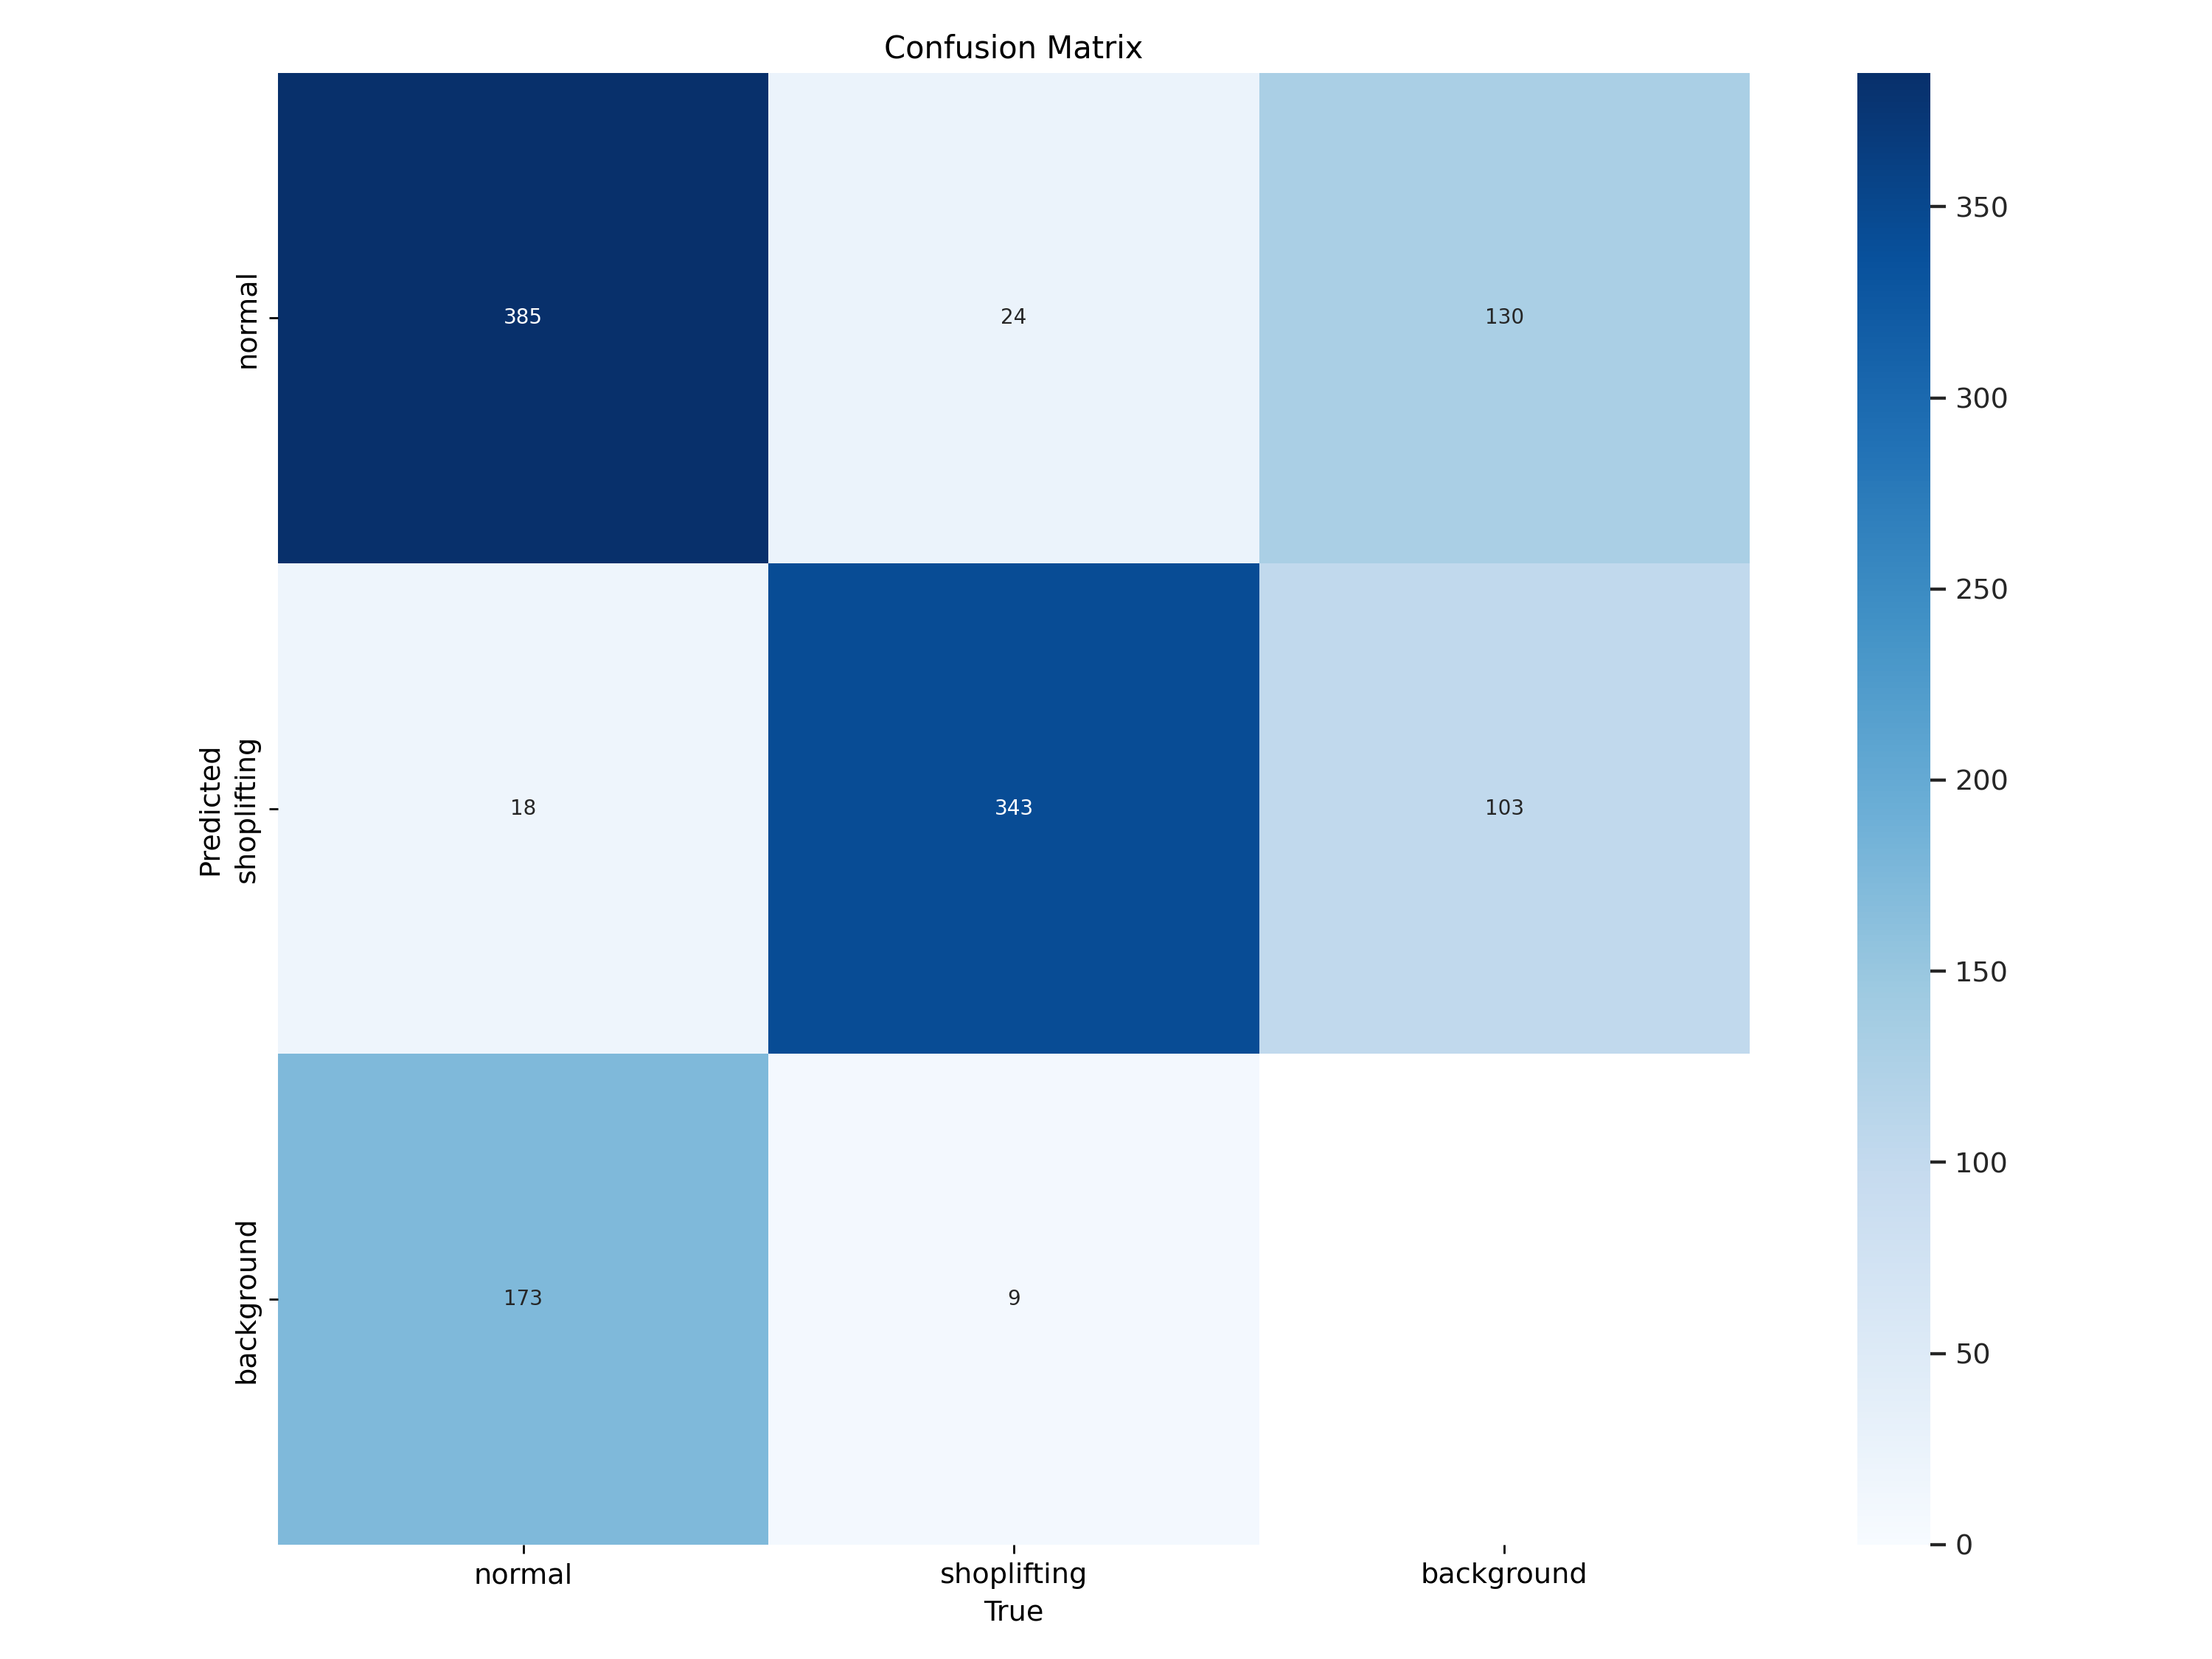

In [21]:
from IPython.display import Image

Image(filename=f'/content/runs/detect/train3/confusion_matrix.png', width=1000)

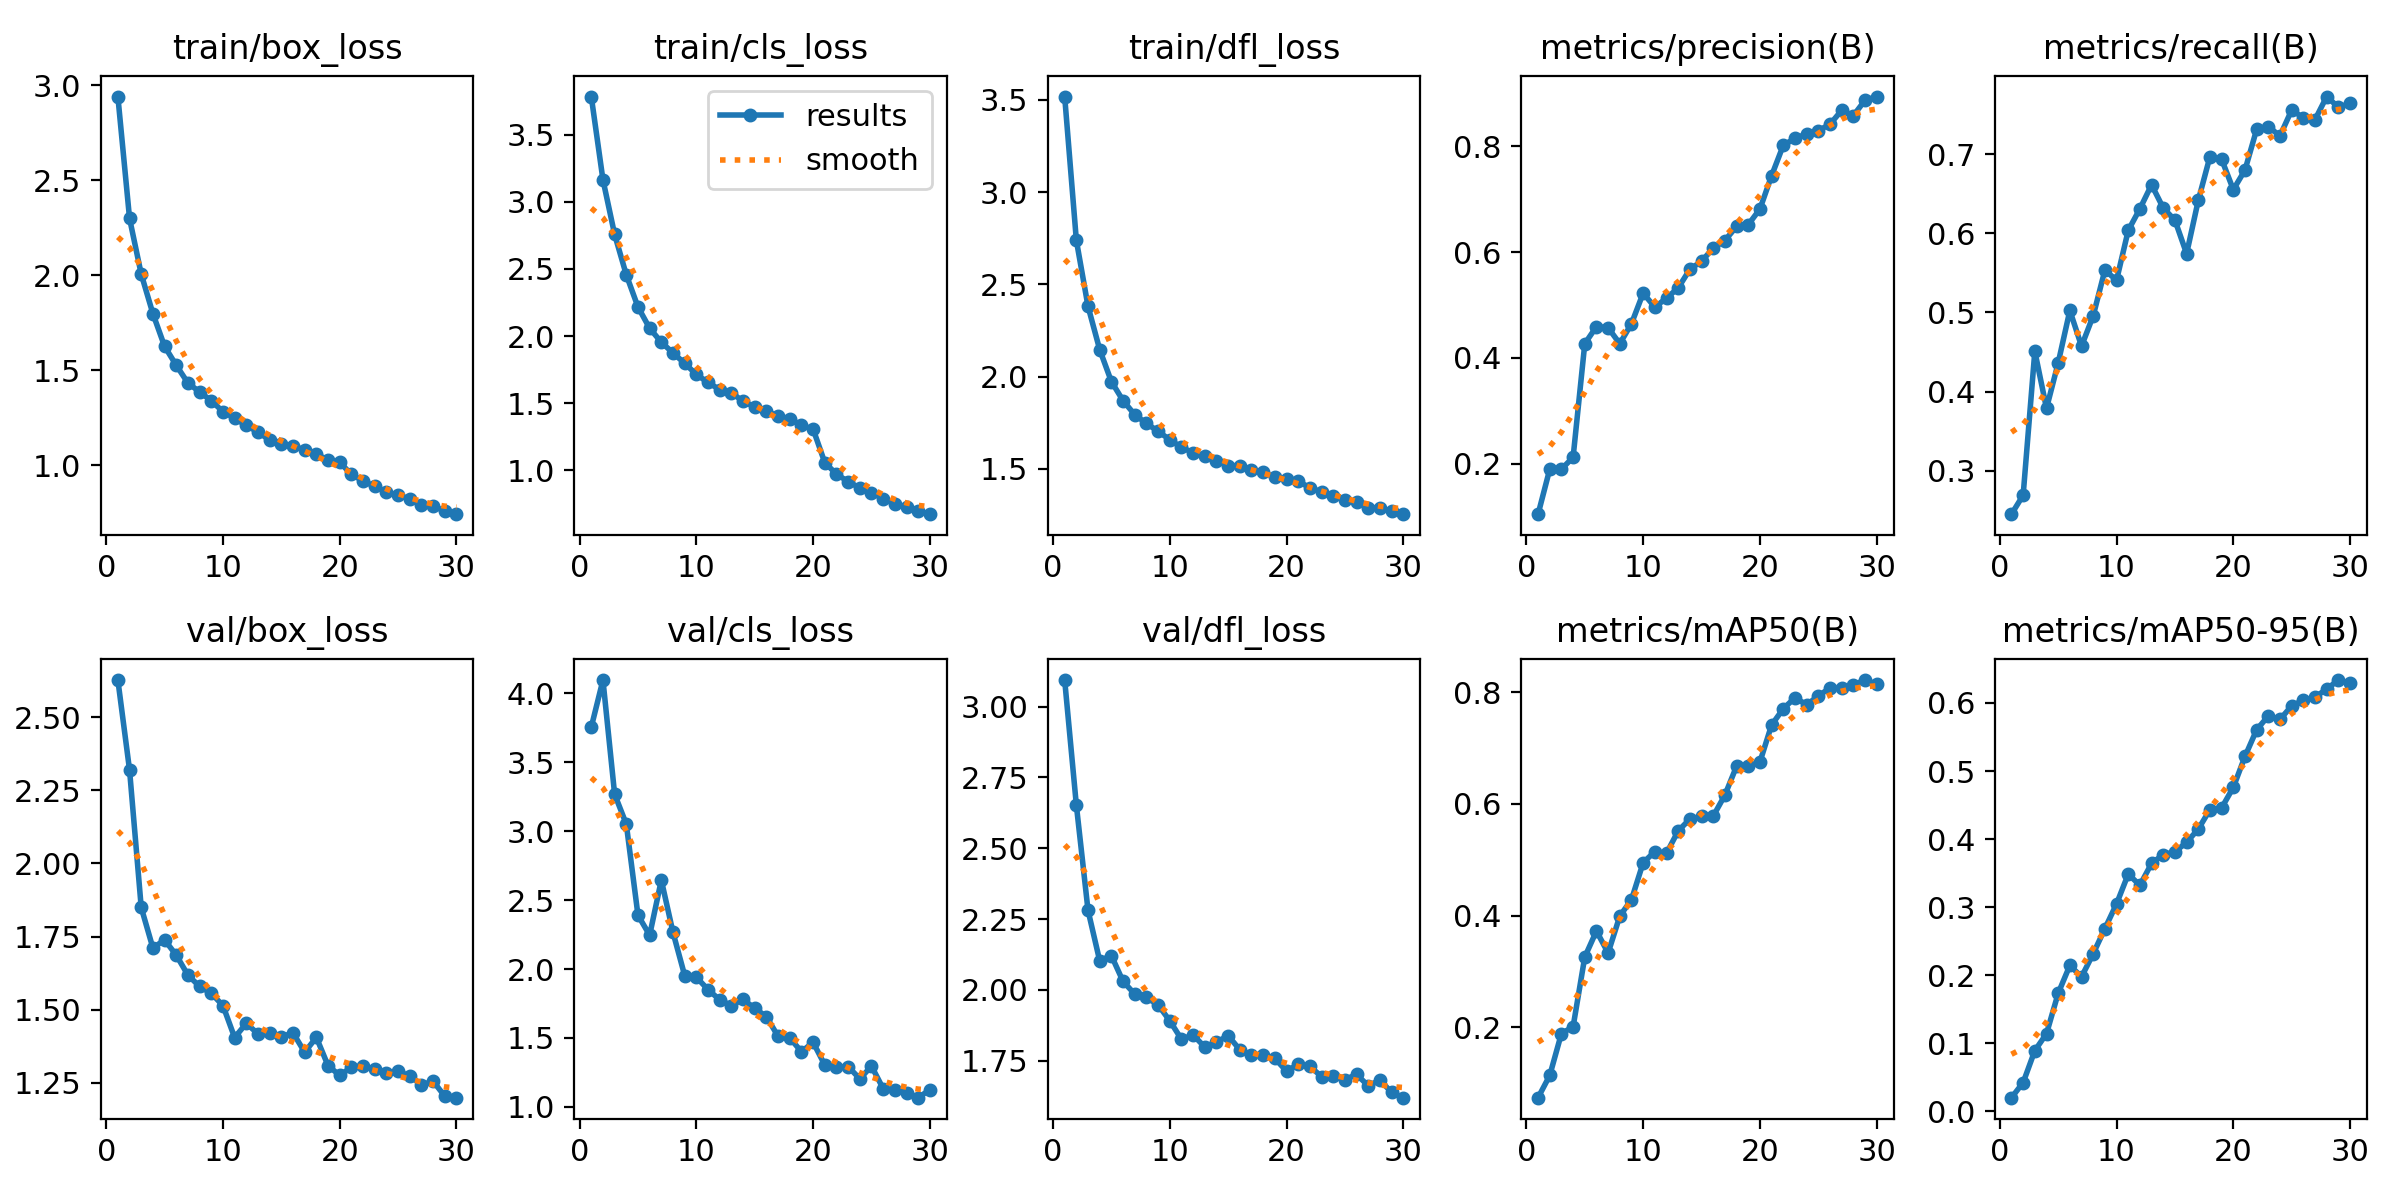

In [22]:
from IPython.display import Image

Image(filename=f'/content/runs/detect/train3/results.png', width=1000)

In [25]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"/content/data/test/images",
    annotations_directory_path=f"/content/data/test/labels",
    data_yaml_path=f"/content/data/data.yaml"
)

ds.classes

['normal', 'shoplifting']

In [26]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/content/runs/detect/train3/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [27]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.32752405944707597
mAP 50 0.43903942302790294
mAP 75 0.35949092936713056


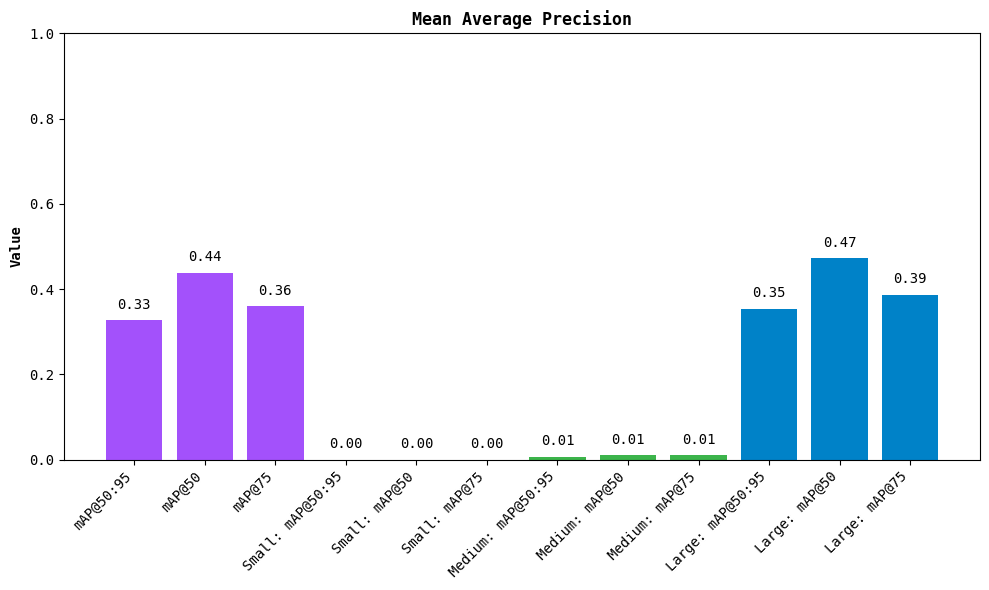

In [28]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [30]:
import supervision as sv

model = YOLO(f'/content/runs/detect/train3/weights/best.pt')



ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"/content/data/test/images",
    annotations_directory_path=f"/content/data/test/labels",
    data_yaml_path=f"/content/data/data.yaml"
)

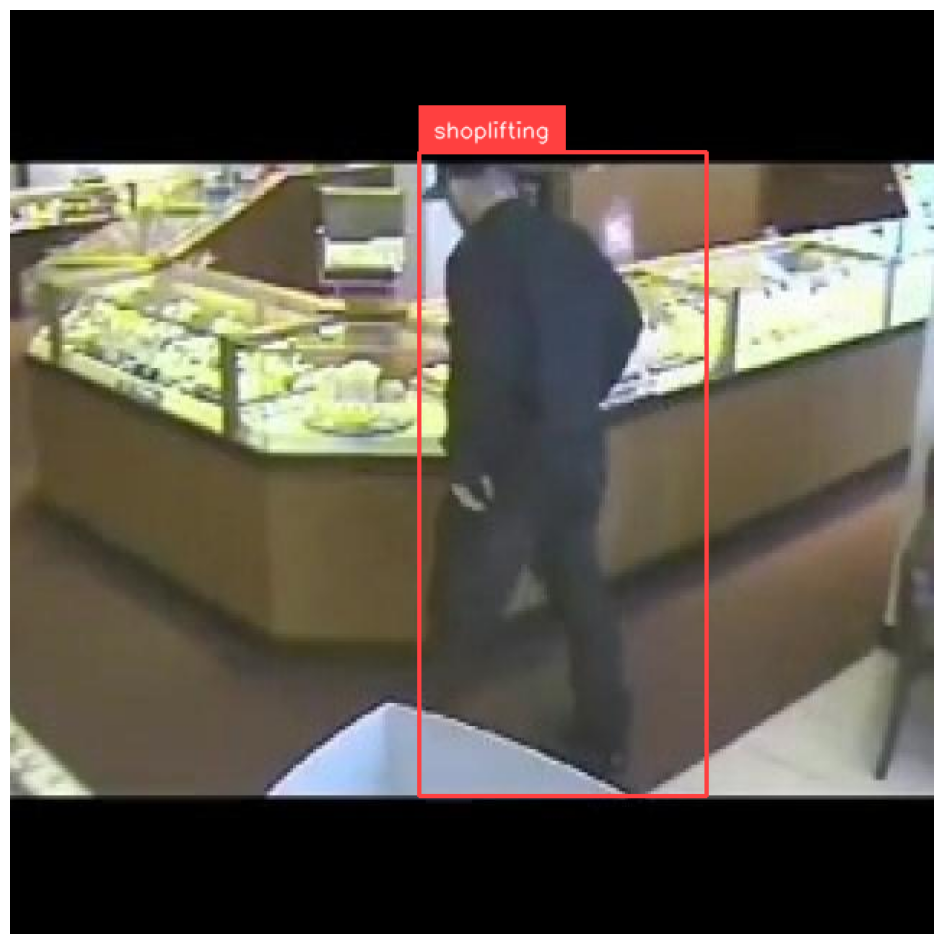

In [31]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)